In [2]:
## import libs
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

(612, 612, 3)
(800, 1500, 3)


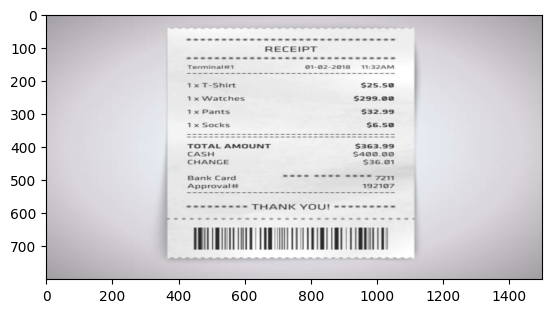

In [8]:
im_path = "/home/krushang/radhey/love/personal/Doc-Scanner-Project/assets/img/img1.jpg"
# read image from path
img = cv2.imread(im_path)
print(img.shape)

# img resize
img = cv2.resize(img, (1500, 800))
# BGR format: BGR -> RGB
print(img.shape)

plt.imshow(img)
plt.show()

- Remove The Noise
- Edge Detection
- Contour Selection
- Best Contour Selection
- Project to the screen

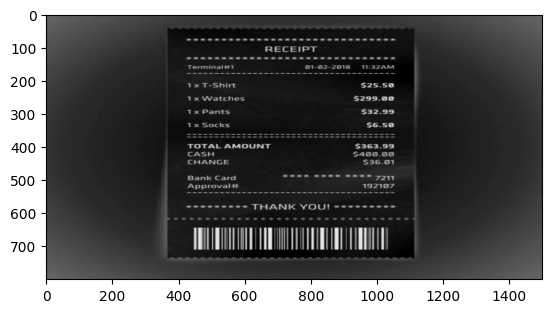

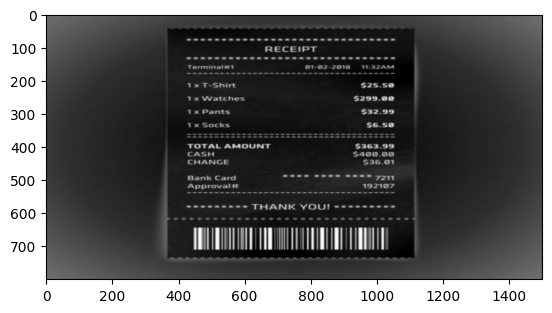

In [14]:
# Remove the noise

# image blurring

orig = img.copy()
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="binary")
plt.show()

blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap="binary")
plt.show()

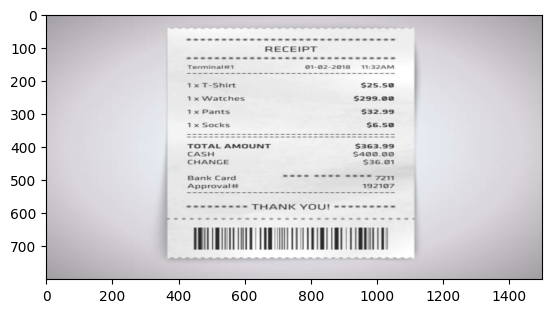

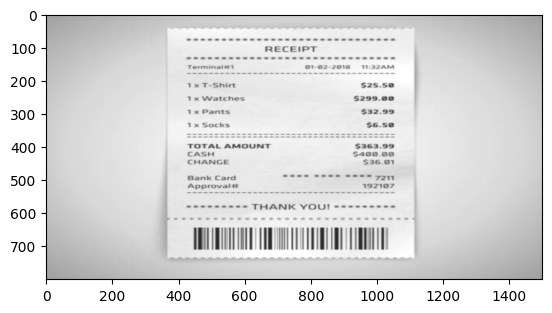

In [16]:
regen = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)
plt.imshow(orig)
plt.show()

plt.imshow(regen)
plt.show()

In [17]:
regen.shape

(800, 1500, 3)

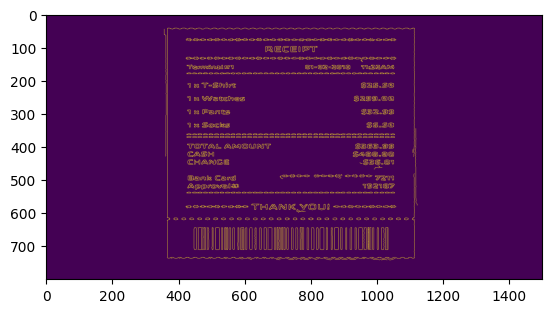

In [18]:
# edge detection 

edge = cv2.Canny(blurred, 0, 50)
orig_edge = edge.copy()

plt.imshow(orig_edge)
plt.show()